Name: Bharat Sharma
Roll No: 240265

# Task 1

#### Q table initialization


In [2]:
import numpy as np

def init_q_table(n_states, n_actions):
    return np.zeros((n_states, n_actions))


$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

In [3]:
def q_update(Q, s, a, r, s_next, alpha, gamma):
    """
    Update the Q-table using the Q-learning update rule.

    Parameters:
    - Q (np.ndarray): Current Q-table.
    - s (int): Current state.
    - a (int): Action taken.
    - r (float): Reward received.
    - s_next (int): Next state.
    - alpha (float): Learning rate.
    - gamma (float): Discount factor.

    Returns:
    - np.ndarray: Updated Q-table.
    """
    best_next_action_value = np.max(Q[s_next])
    td_target = r + gamma * best_next_action_value
    td_error = td_target - Q[s, a]
    Q[s, a] += alpha * td_error
    return Q


# Task 2

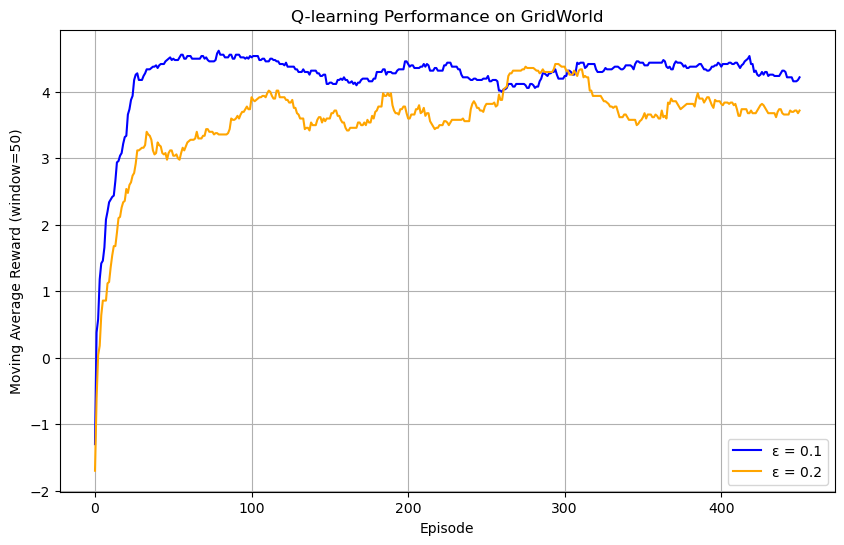

In [4]:
import random
import matplotlib.pyplot as plt
import gym
from gym import spaces

# Define the GridWorld Environment
class GridWorldEnv(gym.Env):
    def __init__(self):
        self.grid_size = 4
        self.n_states = self.grid_size * self.grid_size
        self.action_space = spaces.Discrete(4)  # 0=up, 1=down, 2=left, 3=right
        self.observation_space = spaces.Discrete(self.n_states)
        self.terminal_states = [15]  # bottom-right corner
        self.rewards = np.full(self.n_states, -1.0)
        self.rewards[15] = 10.0
        self.start_state = 0
        self.state = self.start_state

    def reset(self):
        self.state = self.start_state
        return self.state

    def state_to_pos(self, state):
        return state // self.grid_size, state % self.grid_size

    def pos_to_state(self, row, col):
        return row * self.grid_size + col

    def step(self, action):
        row, col = self.state_to_pos(self.state)

        if action == 0:  # up
            row = max(0, row - 1)
        elif action == 1:  # down
            row = min(self.grid_size - 1, row + 1)
        elif action == 2:  # left
            col = max(0, col - 1)
        elif action == 3:  # right
            col = min(self.grid_size - 1, col + 1)

        next_state = self.pos_to_state(row, col)
        reward = self.rewards[next_state]
        done = next_state in self.terminal_states

        self.state = next_state
        return next_state, reward, done, {}

# Q-learning update function
def q_update(Q, s, a, r, s_next, alpha, gamma):
    max_next = np.max(Q[s_next])
    Q[s, a] = Q[s, a] + alpha * (r + gamma * max_next - Q[s, a])
    return Q

# ε-greedy action selection
def select_action(Q, state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, Q.shape[1] - 1)
    else:
        return np.argmax(Q[state])

# Train Q-learning agent
def train_agent(env, epsilon, alpha=0.1, gamma=0.9, episodes=500):
    Q = np.zeros((env.n_states, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = select_action(Q, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            Q = q_update(Q, state, action, reward, next_state, alpha, gamma)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    return Q, rewards

# Moving average function
def moving_average(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Main Execution
env = GridWorldEnv()
Q_01, rewards_01 = train_agent(env, epsilon=0.1)
Q_02, rewards_02 = train_agent(env, epsilon=0.2)

ma_01 = moving_average(rewards_01)
ma_02 = moving_average(rewards_02)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ma_01, label='ε = 0.1', color='blue')
plt.plot(ma_02, label='ε = 0.2', color='orange')
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward (window=50)')
plt.title('Q-learning Performance on GridWorld')
plt.legend()
plt.grid(True)
plt.show()


## Interpretation of Q-Learning Results

The moving average reward plot comparing ε=0.1 and ε=0.2 reveals several important insights about the exploration-exploitation trade-off in our GridWorld environment:

### Learning Performance
Both agents successfully learn to navigate the GridWorld, with rewards converging around **4-5 points**. This indicates they've learned efficient paths to the goal state (position 15) while minimizing the -1 step penalties.

### Exploration vs Exploitation Trade-off
- **ε=0.1 (Blue line)**: Shows **higher and more stable performance** with less variance. The lower exploration rate allows the agent to exploit learned optimal policies more consistently, resulting in better average rewards (~4.5).

- **ε=0.2 (Orange line)**: Exhibits **lower average performance** (~3.5-4.0) with greater fluctuation throughout training. The higher exploration rate means the agent frequently takes suboptimal exploratory actions, leading to more step penalties and reduced cumulative rewards.

### Convergence Behavior
- The ε=0.1 agent reaches stable, high performance faster and maintains it consistently
- The ε=0.2 agent shows more erratic behavior due to continued exploration, preventing it from fully exploiting the optimal policy

### Key Insight
In this **deterministic GridWorld environment** with a clear optimal path, **lower exploration (ε=0.1) is more effective**. The negative step rewards (-1 per move) create a strong incentive to find and stick to the shortest path, making excessive exploration counterproductive. This demonstrates that optimal exploration rates depend heavily on environment characteristics and reward structures.


# Task 3

In [25]:
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        # If buffer not yet full, expand it
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        # Overwrite the oldest transition
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones, dtype=bool)
        )

    def sample_torch(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


# --------- Demonstration ---------

# 1) Create buffer with capacity 100
buffer = ReplayBuffer(capacity=100)

# 2) Fill with 100 random transitions
for _ in range(100):
    state      = random.randint(0, 9)        # e.g. integer state
    action     = random.randint(0, 3)        # e.g. 4 possible actions
    reward     = random.random()             # float reward
    next_state = random.randint(0, 9)
    done       = random.choice([True, False])# boolean flag
    buffer.push(state, action, reward, next_state, done)

# 3) Sample a batch of 32
states, actions, rewards, next_states, dones = buffer.sample(batch_size=32)

# 4) Print shapes and dtypes
print(f"states:      shape={states.shape},      dtype={states.dtype}")
print(f"actions:     shape={actions.shape},     dtype={actions.dtype}")
print(f"rewards:     shape={rewards.shape},     dtype={rewards.dtype}")
print(f"next_states: shape={next_states.shape}, dtype={next_states.dtype}")
print(f"dones:       shape={dones.shape},       dtype={dones.dtype}")


states:      shape=(32,),      dtype=int64
actions:     shape=(32,),     dtype=int64
rewards:     shape=(32,),     dtype=float64
next_states: shape=(32,), dtype=int64
dones:       shape=(32,),       dtype=bool


# Task 4

We define the neural network architectures used for the Deep Q-Network (DQN) agent: the policy network and the target network. Both networks share the same structure and are implemented using PyTorch.

## Architecture Details

- **Input Layer:** Accepts the environment's observation (state) as input. For CartPole-v1, this is a 4-dimensional vector.
- **Hidden Layers:** Two fully connected (linear) layers, each with 128 units and ReLU activation functions to introduce non-linearity.
- **Output Layer:** Outputs a vector of Q-values, one for each possible action in the environment.

This architecture enables the agent to estimate the expected future reward (Q-value) for each action given the current state, which is essential for learning optimal policies.

## Code Components

- `DQNPolicy` and `DQNTarget`: PyTorch `nn.Module` classes implementing the neural networks for the policy and target Q-functions.
- `update_target`: A function to copy the weights from the policy network to the target network, ensuring the target network lags behind for stable training.

The same architecture is used for both networks, allowing the DQN algorithm to leverage deep learning for value function approximation in environments with large or continuous state spaces.

In [28]:
import torch
import torch.nn as nn

class DQNPolicy(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(DQNPolicy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        # Expect x of shape (batch_size, obs_dim)
        return self.net(x)


class DQNTarget(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(DQNTarget, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)


def update_target(target_net_dict, target_net):
    """
    Copy all weights from policy_net to target_net.
    """
    target_net.load_state_dict(target_net_dict)


# --- Example instantiation ---
# (Uncomment and adjust once you have env defined)
import gymnasium as gym
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_net = DQNPolicy(obs_dim, action_dim)
target_net = DQNTarget(obs_dim, action_dim)
update_target(policy_net.state_dict(), target_net)


# Task 5

In Task 5, we implement and train a Deep Q-Network (DQN) agent to solve the CartPole-v1 environment using PyTorch. The DQN algorithm extends Q-learning by using a neural network to approximate the Q-value function, enabling it to handle environments with large or continuous state spaces.

## Approach Overview

- **Neural Network Q-Function Approximation**:
  Instead of a table, a neural network (the policy network) is used to estimate Q-values for all actions given a state. This allows the agent to generalize across similar states.

- **Experience Replay Buffer**:
  The agent stores its experiences (state, action, reward, next state) in a replay buffer. During training, random mini-batches are sampled from this buffer to break the correlation between consecutive experiences, improving learning stability and efficiency.

- **Target Network**:
  A separate target network is maintained, which is a delayed copy of the policy network. The target network is used to compute the target Q-values in the Bellman update, reducing oscillations and divergence during training. The target network is updated towards the policy network using a soft update rule.

- **Epsilon-Greedy Exploration**:
  The agent selects actions using an epsilon-greedy policy: with probability ε, it chooses a random action (exploration), and with probability 1-ε, it chooses the action with the highest predicted Q-value (exploitation). Epsilon decays over time to shift from exploration to exploitation as learning progresses.

- **Training Loop**:
  For each episode:
  1. The environment is reset and the agent interacts with it, selecting actions and collecting experiences.
  2. Each experience is stored in the replay buffer.
  3. After each step, a mini-batch is sampled from the buffer and the policy network is updated by minimizing the loss between predicted Q-values and target Q-values (computed using the target network and the Bellman equation).
  4. The target network is softly updated towards the policy network.

- **Performance Monitoring**:
  The duration (number of steps survived) for each episode is recorded. A moving average of episode durations is plotted to visualize learning progress. The final success rate is computed as the percentage of episodes where the agent achieves a reward above a threshold (e.g., 195).

## Key DQN Components in Code

- `DQNPolicy` and `DQNTarget`: Neural network classes for the policy and target Q-networks.
- `ReplayMemory`: Implements the experience replay buffer.
- `select_action`: Epsilon-greedy action selection function.
- `optimize_model`: Samples a batch from the replay buffer and performs a gradient descent step to update the policy network.
- Training loop: Runs episodes, collects experiences, updates networks, and tracks performance.

This approach enables the agent to learn an effective policy for balancing the pole by leveraging deep reinforcement learning techniques, stabilizing training with experience replay and target networks, and efficiently exploring the environment.

In [29]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [33]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [34]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQNPolicy(n_observations, n_actions).to(device)
target_net = DQNTarget(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [35]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [44]:
from tqdm import tqdm

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 2000
else:
    num_episodes = 50

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            break

print('Complete')


100%|██████████| 2000/2000 [26:32<00:00,  1.26it/s]

Complete


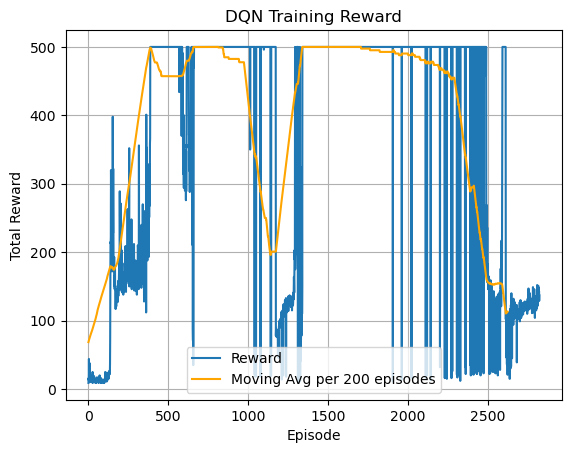


 Final success rate for training loop: 71.80% (2027/2823 episodes with reward ≥ 195)


In [45]:
# Plotting the training progress to see the improvement in the model
def moving_avg(values, window):
    if len(values) < window:
        return []

    moving_averages = []
    cumulative_sum = 0.0

    for i in range(len(values)):
        cumulative_sum += values[i]

        if i >= window:
            cumulative_sum -= values[i - window]
            moving_averages.append(cumulative_sum / window)
        elif i == window - 1:
            moving_averages.append(cumulative_sum / window)

    return moving_averages


plt.plot(episode_durations, label='Reward')
moving_avg_values = moving_avg(episode_durations, num_episodes//10)

if moving_avg_values != []:
    plt.plot(moving_avg_values, label=f'Moving Avg per {num_episodes//10} episodes', color='orange')
plt.title("DQN Training Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()


success_episodes = sum(r >= 195 for r in episode_durations)
success_rate = 100.0 * success_episodes / len(episode_durations)
print(f"\n Final success rate for training loop: {success_rate:.2f}% ({success_episodes}/{len(episode_durations)} episodes with reward ≥ 195)")